In [23]:
import os, numpy as np, matplotlib.pyplot as plt, rampy as rp
from matplotlib.backends.backend_pdf import PdfPages

In [10]:
os.chdir("../drug_test_spontaneous/")

In [11]:
os.getcwd()

'/mnt/d/Work/UCSD/Shi_lab/Donepezil_project/drug_test_spontaneous'

In [2]:
def plot_raman_txt(path, clip_below_zero=True, ax=None, label=None, **plot_kwargs):
    data = np.loadtxt(path)
    if data.ndim != 2 or data.shape[1] < 2:
        raise ValueError(f"Expected at least 2 columns in {path}, got shape {data.shape}")

    shift = data[:, 0]
    intensity = data[:, 1]

    if clip_below_zero:
        intensity = np.where(intensity < 0, 0.0, intensity)

    if ax is None:
        _, ax = plt.subplots()

    if label is None:
        label = os.path.basename(path)

    ax.plot(shift, intensity, label=label, **plot_kwargs)
    ax.set_xlabel("Raman shift (cm$^{-1}$)")
    ax.set_ylabel("Intensity (a.u.)")
    ax.legend()

    return shift, intensity, ax

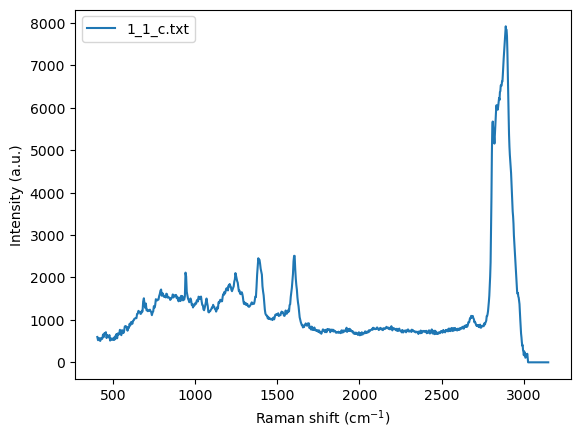

In [4]:
shift, inten, ax = plot_raman_txt("../drug_test_spontaneous/day35/0.1/1_1_c.txt")
plt.show()

### L2 normalization

In [5]:
def best_shift_cos(x_ref, y_ref, x, y, region=(2800, 3050), shifts=np.arange(-80, 81, 1), eps=1e-12):
    m = (x_ref >= region[0]) & (x_ref <= region[1])
    xr = x_ref[m]

    yr = np.interp(xr, x_ref, y_ref)
    yr = yr - yr.mean()
    yr = yr / (np.linalg.norm(yr) + eps)

    best_s, best_c = 0.0, -1.0
    for s in shifts:
        ys = np.interp(xr, x + s, y, left=0.0, right=0.0)
        ys = ys - ys.mean()
        ys = ys / (np.linalg.norm(ys) + eps)
        c = float(yr @ ys)  # cosine similarity
        if c > best_c:
            best_c, best_s = c, float(s)
    return best_s, best_c

In [17]:
def plot_avg_raman_dirs(dirs, labels, band_k=None, alpha=0.3,
                       title="Raman spectra", normalize=True, eps=1e-12, detailed=False,
                       align=True, align_region=(2800, 3050), shift_max=100, shift_step=1,
                       save_path=None):

    # ---------- global x_ref ----------
    d0_files = sorted([os.path.join(dirs[0], f) for f in os.listdir(dirs[0]) if f.endswith("c.txt")])
    if not d0_files:
        raise ValueError(f"No *c.txt files in {dirs[0]}")
    x_ref = np.loadtxt(d0_files[0])[:, 0]

    def _shift_y(y, s_cm):
        # y_shift(x) = y(x + s)  (constant shift in cm^-1)
        return np.interp(x_ref + s_cm, x_ref, y, left=0.0, right=0.0)

    def _cosine(a, b):
        a = a - a.mean()
        b = b - b.mean()
        return float((a @ b) / ((np.linalg.norm(a) + eps) * (np.linalg.norm(b) + eps)))

    def _best_shift(ref_y, y):
        m = (x_ref >= align_region[0]) & (x_ref <= align_region[1])
        shifts = np.arange(-shift_max, shift_max + shift_step, shift_step)

        best_s, best_c = 0.0, -1e9
        for s in shifts:
            y_s = _shift_y(y, s)
            c = _cosine(ref_y[m], y_s[m])
            if c > best_c:
                best_c, best_s = c, float(s)
        return best_s

    # ---------- load each folder -> mean/std band on x_ref (NO shifting yet) ----------
    folder_data = []
    for d in dirs:
        files = sorted([os.path.join(d, f) for f in os.listdir(d) if f.endswith("c.txt")])
        if not files:
            raise ValueError(f"No *c.txt files in {d}")

        Y = np.zeros((x_ref.size, len(files)))
        for i, f in enumerate(files):
            spec = np.loadtxt(f)
            Y[:, i] = rp.resample(spec[:, 0], spec[:, 1], x_ref)

        mean = Y.mean(axis=1)
        std  = Y.std(axis=1, ddof=1) if Y.shape[1] > 1 else np.zeros_like(mean)

        mean = np.maximum(mean, 0.0)  # clip AFTER stats
        if band_k is not None:
            lo = np.maximum(mean - band_k * std, 0.0)
            hi = np.maximum(mean + band_k * std, 0.0)
        else:
            lo = hi = None

        folder_data.append([mean, lo, hi])

    # ---------- align folder MEANS to the first folder MEAN ----------
    shifts_used = [0.0] * len(dirs)
    ref_mean = folder_data[0][0]

    if align:
        for k in range(1, len(dirs)):
            mean, lo, hi = folder_data[k]
            s = _best_shift(ref_mean, mean)
            shifts_used[k] = s

            folder_data[k][0] = _shift_y(mean, s)
            if band_k is not None:
                folder_data[k][1] = _shift_y(lo, s)
                folder_data[k][2] = _shift_y(hi, s)

    # ---------- prepare PDF (if requested) ----------
    pdf = None
    if save_path is not None:
        if not save_path.lower().endswith(".pdf"):
            save_path = f"{save_path}.pdf"
        save_dir = os.path.dirname(save_path)
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
        pdf = PdfPages(save_path)

    # ---------- region list ----------
    regions = []
    if detailed:
        for start in range(600, 1800, 200):
            end = min(start + 200, 1800)
            regions.append(((start, end), f"Fingerprint {start}-{end}"))
    else:
        regions.append(((600, 1800), "Fingerprint region"))
    regions.append(((2800, 3050), "CH-stretch region"))

    # ---------- plot ----------
    for (xmin, xmax), region_name in regions:
        fig, ax = plt.subplots()
        for (mean, lo, hi), label, s in zip(folder_data, labels, shifts_used):
            m = (x_ref >= xmin) & (x_ref <= xmax)

            # L2-normalize WITHIN THIS PLOT WINDOW
            if normalize:
                denom = np.linalg.norm(mean[m]) + eps
                mean_plot = mean[m] / denom
                if band_k is not None:
                    lo_plot = lo[m] / denom
                    hi_plot = hi[m] / denom
            else:
                mean_plot = mean[m]
                if band_k is not None:
                    lo_plot = lo[m]
                    hi_plot = hi[m]

            (line,) = ax.plot(x_ref[m], mean_plot, label=f"{label} (shift {s:+.0f})")
            if band_k is not None:
                ax.fill_between(x_ref[m], lo_plot, hi_plot, alpha=alpha, color=line.get_color())

        ax.set_title(f"{title} – {region_name}")
        ax.set_xlabel("Raman shift (cm$^{-1}$)")
        ax.set_ylabel("L2-normalized intensity (within window)" if normalize else "Intensity (a.u.)")
        ax.legend()
        fig.tight_layout()

        if pdf is not None:
            pdf.savefig(fig)
            plt.close(fig)

    if pdf is not None:
        pdf.close()

    return shifts_used

In [24]:
dirs = ["day35/0.1/", "day35/1mm/", 
        "day35/cl/"]
labels = ["0.1mM", "1mM", "Ctrl"]
save_path = "plots/day35.pdf"
plot_avg_raman_dirs(dirs, labels = labels, band_k = None, detailed = True, 
                    align = False, save_path=save_path)

[0.0, 0.0, 0.0]

In [25]:
dirs = ["day7/0.1/", "day7/1mm/", "day7/cl/"]
labels = ["0.1mM", "1mM", "Ctrl"]
save_path = "plots/day7.pdf"
plot_avg_raman_dirs(dirs, labels = labels, band_k = None, detailed = True, 
                    align = False, save_path=save_path)

[0.0, 0.0, 0.0]

**Timewise comparison**

In [26]:
dirs = ["day7/0.1/", "day35/0.1/"]
labels = ["day7_0.1", "day35_0.1"]
save_path = "plots/0.1_day7_vs_day35.pdf"
plot_avg_raman_dirs(dirs, labels, band_k = None, detailed = True, align = True, save_path = save_path)

[0.0, -40.0]

In [27]:
dirs = ["day7/1mm", "day35/1mm/"]
labels = ["day7_1mM", "day35_1mM"]
save_path = "plots/1mM_day7_vs_day35.pdf"
plot_avg_raman_dirs(dirs, labels, band_k = None, detailed = True, align = True, save_path = save_path)

[0.0, -41.0]

In [28]:
dirs = ["day7/cl/", "day35/cl/"]
labels = ["day7_Ctrl", "day35_Ctrl"]
save_path = "plots/Ctrl_day7_vs_day35.pdf"
plot_avg_raman_dirs(dirs, labels, band_k = None, detailed = True, align = True, save_path = save_path)

[0.0, -40.0]